# Comparing Temperatures and Luminosities Between Analyses

This notebook measures global temperatures and luminosities for the samples we are using to verify our method, then compares them to the measurements from literature. While the focus of this work is the measurement of galaxy cluster masses, temperatures and luminosities play an important role in the construction of X-ray mass-observable scaling relations - thus they must also be shown to be consistent with previous work. 

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 60
from xga.samples import ClusterSample
from xga.sources import BaseSource
from xga.xspec import single_temp_apec

## Defining useful functions

In [2]:
# This function is used for getting axis limits for the the one to one comparison plots later
def find_lims(x_dat, y_dat, buffer=0.1):
    # A buffer of some percent (default 10) is added to the max and min values to make the plot 
    #  more easily readable
    lom = 1 - buffer
    him = 1 + buffer
    
    # Reading out the values without errors
    x_vals = x_dat[:, 0]
    y_vals = y_dat[:, 0]
    
    # Depending on whether the input data has + and - errors, or just a standard deviation, depends how
    #  we find maximum and minimum values
    if x_dat.shape[1] == 3:
        # In this case upper and lower errors are present
        lb = x_vals-x_dat[:, 1]
        # Make sure that we don't count any NaN values, and don't count any negative values
        #  The lower errors are subtracted from the measurements, and upper values added to them
        #  Then max and mins are found 
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 2])]
    elif x_dat.shape[1] == 2:
        # The behaviour is largely the same as above, but for symmetrical errors
        lb = x_vals-x_dat[:, 1]
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 1])]
    
    if y_dat.shape[1] == 3:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 2])]
    elif y_dat.shape[1] == 2:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 1])]
    
    # Then find the minimum and maximum values from the min and max x and y data, and multiply by the buffer
    lims = Quantity([lom*min([x_lims[0], y_lims[0]]), him*max([x_lims[1], y_lims[1]])])
    
    # Return the limits for the square like for like comparison plot
    return lims

## Setting up cosmology

Though three of the previous analyses use the same concordance cosmology, the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define four separate cosmology objects to pass into our samples.

In [3]:
xcs_cosmo = LambdaCDM(70, 0.3, 0.7)
xxl_cosmo = WMAP9
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### SDSSRM-XCS Volume Limited

This is the recent SDSSRM-XCS sample. The temperatures and luminosities are measured by the XCS luminosity-temperature pipeline, and with this we demonstrate that XGA temperatures and luminosities are consistent with existing XCS results.

In order to achieve maximum consistency, we use the XAPA coordinates as the central position for spectrum generation (turning off the XGA peak finder with `use_peak=False`). We have also made sure to use the same cosmology.

$\color{red}{\text{UNBLACKLIST 0763910701 ONCE PAUL HAS RE-REDUCED IT - THAT WILL RE-INCLUDE SDSSXCS-5977}}$

In [4]:
xcs3p = pd.read_csv("sample_files/xcs3p_sdssrm_vol_lim_temperr_25%_clusters.csv")

In [5]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p['xapa_ra'].values
dec = xcs3p['xapa_dec'].values
z = xcs3p['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p['name'].values
# In arcminutes, ClusterSample declaration will convert to kpc using the provided cosmology
r500 = Quantity(xcs3p['r500'].values, 'arcmin')
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p['richness'].values
r_err = xcs3p['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
xcs_srcs = ClusterSample(ra, dec, z, n, r500=r500, richness=r, richness_err=r_err, cosmology=xcs_cosmo, 
                         load_fits=True, use_peak=False, clean_obs=True, clean_obs_reg='r500', 
                         clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   7%|██▉                                         | 10/150 [00:08<01:54,  1.22it/s]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-2346 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   8%|███▌                                        | 12/150 [00:12<03:17,  1.43s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-11331 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   9%|███▊                                

Setting up Galaxy Clusters:  21%|█████████▍                                  | 32/150 [01:28<10:16,  5.23s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0677590135 and is very close to the user supplied coordinates of SDSSXCS-8366. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-8366 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  22%|█████████▋                                  | 33/150 [01:35<11:37,  5.96s/it]/its/home/dt237

Setting up Galaxy Clusters:  49%|█████████████████████▍                      | 73/150 [03:15<04:44,  3.69s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0601260201 and is very close to the user supplied coordinates of SDSSXCS-10401. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
Setting up Galaxy Clusters:  49%|█████████████████████▋                      | 74/150 [03:16<03:43,  2.94s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-58896 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Ga

Setting up Galaxy Clusters:  85%|████████████████████████████████████▍      | 127/150 [07:14<00:29,  1.30s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-30950 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  86%|████████████████████████████████████▉      | 129/150 [07:18<00:37,  1.77s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0093031601, associated with source SDSSXCS-14
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/sources/general.py:124: UserWarning: SDSSXCS-14 has not been detect

### XXL-100-GC

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [6]:
xxlgc100 = pd.read_csv("sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [7]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                                                                                                                                                             | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|█▊                                                                                                                                                                                   | 1/99 [00:06<10:34,  6.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'reg

Setting up Galaxy Clusters:  13%|███████████████████████▋                                                                                                                                                            | 13/99 [01:33<09:56,  6.93s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-83 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  14%|█████████████████████████▍                                                                                                                                                          | 14/99 [01:38<08:48,  6.21s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-84 has not been detected in all region files, so generating and fitting products with the 'reg

Setting up Galaxy Clusters:  25%|█████████████████████████████████████████████▍                                                                                                                                      | 25/99 [03:08<13:18, 10.80s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-23 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  26%|███████████████████████████████████████████████▎                                                                                                                                    | 26/99 [03:15<11:41,  9.61s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0037980101, associated with source XLSSC-6
  warning

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0109520301 and is very close to the user supplied coordinates of XLSSC-11. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0780451301 and is very close to the user supplied coordinates of XLSSC-11. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0780452601 and is very close to the user supplied coordinates of XLSSC-11. It will not be excluded from analysis du

Setting up Galaxy Clusters:  48%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 48/99 [08:48<09:08, 10.75s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-87 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  49%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 49/99 [08:56<08:12,  9.85s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-91 has not been detected in all region files, so generating and fitting products with the 'reg

Setting up Galaxy Clusters:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 61/99 [10:02<02:53,  4.58s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-518 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 62/99 [10:06<02:39,  4.31s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0604873944, associated with source XLSSC-531
  warn

Setting up Galaxy Clusters:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 73/99 [11:06<02:22,  5.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-522 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/99 [11:11<02:14,  5.39s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-533 has not been detected in all region files, so generating and fitting products with the 'r

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:2437: UserWarning: Existing fit for XLSSC-511 could not be loaded due to a mismatch in available data
  self._existing_xga_products(self._load_fits)
Setting up Galaxy Clusters: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [13:29<00:00,  8.18s/it]


### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [8]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [9]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|████████████████████████████████████████████████████████████████▍                                                                                                                  | 18/50 [03:23<05:37, 10.53s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 23/50 [04:30<06:25, 14.29s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will n

Setting up Galaxy Clusters:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 27/46 [04:00<02:22,  7.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: Abell1689 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 29/46 [04:17<02:15,  7.99s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: Abell1758N has not been detected in all region files, so generating and fitting products with the '

### Planck Selected with XMM follow-up

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements. We choose to use the XMM derived X-ray peak coordinates, rather than the Planck positions:

In [10]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [11]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['xmm_ra'].values
dec = lovisari['xmm_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=False, use_peak=False, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 60/120 [12:17<09:27,  9.46s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 61/120 [12:36<12:12, 12.41s/it]/mnt/pact/dt237/

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning:

Setting up Galaxy Clusters:  50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 60/120 [11:02<08:14,  8.24s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Setting up Galaxy Clusters:  51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 61/120 [11:14<09:13,  9.39s/it]/mnt/pact/dt237/

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0603050101/0603050101_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0603050101/0603050101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning:

One of the Lovisari clusters didn't make it past the cleaning step performed by the ClusterSample, G272.10-40.15 - this is a large (~1300kpc) low-redshift (0.059) cluster and all of the observations are offset.

In [66]:
print(lovisari_srcs.failed_names)

['G272.10-40.15']


## Running $T_{\rm{X}}$ and $L_{\rm{X}}$ Measurements

The XGA XSPEC functions that we use here all automatically call the XGA SAS interface, so the necessary spectra are generated before the fits begin. As the different samples measure properties within different spatial regions, all the function calls differ slightly.

The results of the fits are stored within the indivual source objects that make up each sample.

###  SDSSRM-XCS

For our comparisons here we wish to measure the temperature ($T_{\rm{X}}$) and luminosity ($L_\rm{X}$; both in the 0.5-2.0 keV and bolometric/0.01-100.0 keV energy bands) within $R_{\rm{500}}$. We fit a `constant*tbabs*apec` model; $\color{red}{\text{with the choices for absorption (`tbabs`) and plasma emission (`tbabs`) consistent with the XCS analysis, though the addition of a multiplicative constant to manage differences in sensitivity is different from the original analysis.}}$

In [6]:
single_temp_apec(xcs_srcs, xcs_srcs.r500)

Running XSPEC Fits:  99%|█████████████████████████████████████████████████▋| 138/139 [19:07<03:29, 209.33s/it]/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/xspec/run.py:59: UserWarning: An XSPEC fit for SDSSXCS-21847 has timed out
  warnings.warn("An XSPEC fit for {} has timed out".format(source_name))
Running XSPEC Fits: 100%|█████████████████████████████████████████████████| 139/139 [1:00:04<00:00, 25.93s/it]


### XXL-100-GC

The XXL temperatures and soft-band $L_{\rm{X}}$ are measured within 300 kpc, which we replicate by setting the outer radius to an astropy quantity of 300 kpc.

In [13]:
single_temp_apec(xxl_srcs, Quantity(300, 'kpc'))

Running XSPEC Fits: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:52<00:00, 26.13s/it]


### LoCuSS

The LoCuSS temperatures and luminosities are slightly different, and have been measured with the core of the X-ray emission removed (spectra are generated in the 0.15-1 $R_{500}$ region). This approach has been shown to reduce the scatter in mass with $L_{\rm{X}}$. We can replicate it by setting an inner radius when we call `single_temp_apec`.

In [14]:
single_temp_apec(locuss_srcs, locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500)
single_temp_apec(locuss_srcs, locuss_srcs.r500)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")


### Lovisari 

The Lovisari sample's has both core-excised and core-included temperatures and luminosities, so we shall also measure both. The Lovisari analysis used a different energy range for the soft-band luminosity measurements than the other samples (0.1-2.4 keV). We can replicate this by changing the default luminosity energy bands used by `single_temp_apec`, so we measure core excluded and included luminosities in the 0.5-2.0 keV, 0.01-100.0 keV (bolometric), and 0.1-2.4 keV bands.

In [15]:
# The luminosity energy limits, defined in pairs of upper and lower values
lovisari_lum_en = Quantity([[0.5, 2.0], [0.01, 100.0], [0.1, 2.4]], 'keV')

# Running fits for both R500 and core excluded R500 spectra
single_temp_apec(lovisari_srcs, lovisari_srcs.r500, lum_en=lovisari_lum_en)
single_temp_apec(lovisari_srcs, lovisari_srcs.r500, inner_radius=0.15*lovisari_srcs.r500, 
                 lum_en=lovisari_lum_en)

Running XSPEC Fits: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [08:33<00:00,  4.32s/it]


## Retrieving $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements from the samples

We must extract and judge the quality of the temperature and luminosity measurements that we have made for each of the samples, then later on we will be able to directly compare them. At the same time we make sure that the results from literature are formatted in such a way that we can easily compare them.

### SDSSRM-XCS

In [7]:
sdss_tx_all = xcs_srcs.Tx(xcs_srcs.r500, quality_checks=False).value
sdss_tx = xcs_srcs.Tx(xcs_srcs.r500, quality_checks=True)

sdss_lxbol_all = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                             hi_en=Quantity(100.0, 'keV'))
sdss_lxbol = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=True, lo_en=Quantity(0.01, 'keV'), 
                         hi_en=Quantity(100.0, 'keV'))

sdss_lx_all = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                             hi_en=Quantity(2.0, 'keV'))
sdss_lx = xcs_srcs.Lx(xcs_srcs.r500, quality_checks=True, lo_en=Quantity(0.5, 'keV'), 
                         hi_en=Quantity(2.0, 'keV'))

/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-21847
  warn(str(err))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-2588
  warn(str(err))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-455
  warn(str(err))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-6307
  warn(str(err))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:280: UserWarning: There are no XSPEC fits associated with SDSSXCS-21847
  warn(str(err))
/its/home/dt237/.conda/envs/xga_env/lib/python3.8/site-packages/xga/samples/base.py:280: UserWarning: There are no XSPEC fi

In [8]:
# xcs3p_tx = Quantity(xcs3p[['Tx', 'Tx-', 'Tx+']].values, 'keV')
# xcs3p_lx52 = Quantity(xcs3p[['Lx52', 'Lx52-', 'Lx52+']].values*1e+44, 'erg/s')
# xcs3p_lxbol = Quantity(xcs3p[['Lx', 'Lx-', 'Lx+']].values*1e+44, 'erg/s')

xcs3p_tx = []
xcs3p_lx52 = []
xcs3p_lxbol = []

for src in xcs_srcs:
    n = src.name
    rel_row = xcs3p[xcs3p['name'] == n].iloc[0]
    xcs3p_tx.append(Quantity(rel_row[['Tx', 'Tx-', 'Tx+']].values, 'keV'))
    xcs3p_lx52.append(Quantity(rel_row[['Lx52', 'Lx52-', 'Lx52+']].values*1e+44, 'erg/s'))
    xcs3p_lxbol.append(Quantity(rel_row[['Lx', 'Lx-', 'Lx+']].values*1e+44, 'erg/s'))  

xcs3p_tx = Quantity(xcs3p_tx)
xcs3p_lx52 = Quantity(xcs3p_lx52)
xcs3p_lxbol = Quantity(xcs3p_lxbol)

### XXL-100-GC

In [18]:
xxl_tx_all = xxl_srcs.Tx(Quantity(300, 'kpc'), quality_checks=False)
xxl_tx = xxl_srcs.Tx(Quantity(300, 'kpc'), quality_checks=True)

xxl_lx_all = xxl_srcs.Lx(Quantity(300, 'kpc'), quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                             hi_en=Quantity(2.0, 'keV'))
xxl_lx = xxl_srcs.Lx(Quantity(300, 'kpc'), quality_checks=True, lo_en=Quantity(0.5, 'keV'), 
                         hi_en=Quantity(2.0, 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with XLSSC-102
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with XLSSC-531
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:468: UserWarning: One of the temperature uncertainty values for XLSSC-92 is more than three times larger than the other, this means the fit quality is suspect.
  warn("One of the temperature uncertainty values for {s} is more than three times larger than "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:468: UserWarning: One of the temperature uncertainty values for XLSSC-89 is more than three times larger than the other, this means the fit quality is suspect.
  warn("One of the temperature uncertainty values for {s} is more than three times larger than "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/ext

In [19]:
xxlgc100_tx = []
xxlgc100_lx52 = []
for n in xxl_srcs.names:
    # TODO REMOVE THE IF STATEMENT IT WON'T BE NECESSARY NEXT RUN
    if n != "XLSSC-504":
        rel_row = xxlgc100[xxlgc100['name'] == n].iloc[0]
        xxlgc100_tx.append(Quantity(rel_row[['T300kpc', 'T300kpc-', 'T300kpc+']], 'keV'))
        xxlgc100_lx52.append(Quantity(rel_row[['L52_300kpc', 'L52_300kpc_err']]*1e+43, 'erg/s'))
    else:
        xxlgc100_tx.append(Quantity([np.nan, np.nan, np.nan], 'keV'))
        xxlgc100_lx52.append(Quantity([np.nan, np.nan], 'erg/s'))
    
xxlgc100_tx = Quantity(xxlgc100_tx)
xxlgc100_lx52 = Quantity(xxlgc100_lx52)

### LoCuSS

$\color{red}{\text{SOMETHING WEIRD GOING ON WITH LUM COMPARISON NOW TRYING NON-CORE EXCISED}}$

In [20]:
locuss_txce_all = locuss_srcs.Tx(locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500, quality_checks=False)
locuss_txce = locuss_srcs.Tx(locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500, quality_checks=True)

locuss_lxbocel_all = locuss_srcs.Lx(locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500, quality_checks=False, 
                                    lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))
locuss_lxbolce = locuss_srcs.Lx(locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500, quality_checks=True, 
                                lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))

locuss_lxbol_all = locuss_srcs.Lx(locuss_srcs.r500, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                                  hi_en=Quantity(100.0, 'keV'))
locuss_lxbol = locuss_srcs.Lx(locuss_srcs.r500,  quality_checks=True, lo_en=Quantity(0.01, 'keV'), 
                              hi_en=Quantity(100.0, 'keV'))

In [21]:
loclit_tx = []
loclit_lxbol = []
for n in locuss_srcs.names:
    rel_row = locuss[locuss['name'] == n].iloc[0]
    loclit_tx.append(Quantity(rel_row[['x_Tx500ce', 'x_Tx500ce-', 'x_Tx500ce+']], 'keV'))
    loclit_lxbol.append(Quantity(rel_row[['x_Lxbol', 'x_Lxbol_err']]*1e+44, 'erg/s'))
    
loclit_tx = Quantity(loclit_tx)
loclit_lxbol = Quantity(loclit_lxbol)

### Lovisari

In [22]:
lovisari_txce_all = lovisari_srcs.Tx(lovisari_srcs.r500, inner_radius=0.15*lovisari_srcs.r500, 
                                     quality_checks=False)
lovisari_txce = lovisari_srcs.Tx(lovisari_srcs.r500, inner_radius=0.15*lovisari_srcs.r500, 
                                 quality_checks=True)

lovisari_tx_all = lovisari_srcs.Tx(lovisari_srcs.r500, quality_checks=False)
lovisari_tx = lovisari_srcs.Tx(lovisari_srcs.r500, quality_checks=True)

lovisari_lxce_all = lovisari_srcs.Lx(lovisari_srcs.r500, inner_radius=0.15*lovisari_srcs.r500, 
                                     quality_checks=False, lo_en=Quantity(0.1, 'keV'), hi_en=Quantity(2.4, 'keV'))
lovisari_lxce = lovisari_srcs.Lx(lovisari_srcs.r500, inner_radius=0.15*lovisari_srcs.r500, quality_checks=True, 
                               lo_en=Quantity(0.1, 'keV'), hi_en=Quantity(2.4, 'keV'))

lovisari_lx_all = lovisari_srcs.Lx(lovisari_srcs.r500, quality_checks=False, lo_en=Quantity(0.1, 'keV'), 
                                 hi_en=Quantity(2.4, 'keV'))
lovisari_lx = lovisari_srcs.Lx(lovisari_srcs.r500, quality_checks=True, lo_en=Quantity(0.1, 'keV'), 
                             hi_en=Quantity(2.4, 'keV'))

lovisari_lxbolce_all = lovisari_srcs.Lx(lovisari_srcs.r500, inner_radius=0.15*lovisari_srcs.r500, 
                                        quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                                        hi_en=Quantity(100.0, 'keV'))
lovisari_lxbolce = lovisari_srcs.Lx(lovisari_srcs.r500, inner_radius=0.15*lovisari_srcs.r500, quality_checks=True, 
                                  lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))

lovisari_lxbol_all = lovisari_srcs.Lx(lovisari_srcs.r500, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                                      hi_en=Quantity(100.0, 'keV'))
lovisari_lxbol = lovisari_srcs.Lx(lovisari_srcs.r500, quality_checks=True, lo_en=Quantity(0.01, 'keV'), 
                                  hi_en=Quantity(100.0, 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: Those spectra have no associated XSPEC fit to G006.78+30.46
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with G042.82+56.61
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with G171.94-40.65
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with G229.94+15.29
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with G308.32-20.23
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: These spectra have no associated XSPEC fit to G006.78+30.46.
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: U

In [23]:
lovlit_tx = []
lovlit_lxbol = []
lovlit_lx124 = []

lovlit_txce = []
lovlit_lxbolce = []
lovlit_lx124ce = []

for n in lovisari_srcs.names:
    rel_row = lovisari[lovisari['name'] == n].iloc[0]
    lovlit_tx.append(Quantity(rel_row[['Tx', 'Tx-', 'Tx+']], 'keV'))
    lovlit_lxbol.append(Quantity(rel_row[['Lxbol', 'Lxbol-', 'Lxbol+']]*1e+44, 'erg/s'))
    lovlit_lx124.append(Quantity(rel_row[['Lx124', 'Lx124-', 'Lx124+']]*1e+44, 'erg/s'))
    
    lovlit_txce.append(Quantity(rel_row[['Txce', 'Txce-', 'Txce+']], 'keV'))
    lovlit_lxbolce.append(Quantity(rel_row[['Lxbolce', 'Lxbolce-', 'Lxbolce+']]*1e+44, 'erg/s'))
    lovlit_lx124ce.append(Quantity(rel_row[['Lx124ce', 'Lx124ce-', 'Lx124ce+']]*1e+44, 'erg/s'))
    
lovlit_tx = Quantity(lovlit_tx)
lovlit_lxbol = Quantity(lovlit_lxbol)
lovlit_lx124 = Quantity(lovlit_lx124)

lovlit_txce = Quantity(lovlit_txce)
lovlit_lxbolce = Quantity(lovlit_lxbolce)
lovlit_lx124ce = Quantity(lovlit_lx124ce)

## Direct comparisons between original and XGA measurements

This is the the point of this notebook, making direct comparisons of like for like (or as near as we can achieve) measurements from literature to measurements made using XGA. In each case we plot simple one-to-one comparisons, with a one-to-one dashed line in red to give a reference.

### SDSSRM-XCS

We directly compare temperatures and luminosities (soft band and bolimetric) between the XCS3P pipeline and XGA.

In [9]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(sdss_tx[:, 0]).sum(), 
                                                                  t=len(sdss_tx)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(sdss_lx[:, 0]).sum(), 
                                                                    t=len(sdss_lx)))
print('{s} out of {t} XGA Lxbol measurements were successful'.format(s=np.isfinite(sdss_lxbol[:, 0]).sum(), 
                                                                    t=len(sdss_lxbol)))

145 out of 149 XGA Tx measurements were successful
145 out of 149 XGA Lx52 measurements were successful
145 out of 149 XGA Lxbol measurements were successful


#### $T_{\rm{X}, 500}$, $L^{\rm{0.5-2.0}}_{\rm{X}, 500}$, and $L^{\rm{bol}}_{\rm{X}, 500}$ 

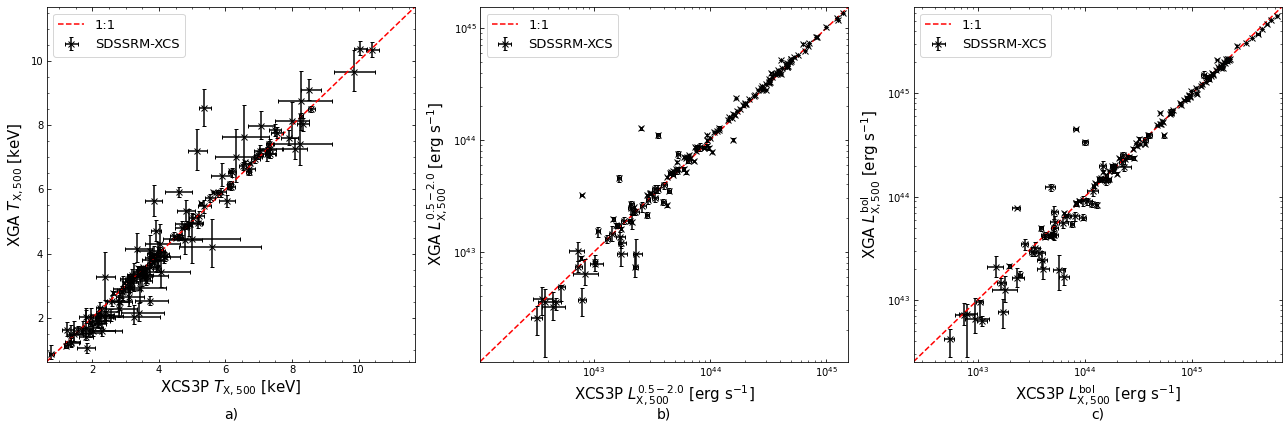

In [10]:
fig, ax_arr = plt.subplots(ncols=3, figsize=(18, 6))

# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.15
sublabel_fsize = 14

# Iterating through the array of axes objects, setting up the ticks
for ax_ind, ax in enumerate(ax_arr):
    # Turning on minor ticks and setting it up so they all point inwards - also turn on ticks on the 
    #  top and right axis lines
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')
    # Add the a, b, c, etc labels below the axes
    ax.text(0.5, sublabel_ypos, s='{})'.format(chr(97+ax_ind)), horizontalalignment='center', 
            verticalalignment='center', transform=ax.transAxes, fontsize=sublabel_fsize)

# Setting the leftmost axis to be current
plt.sca(ax_arr[0])
# Using the function we defined earlier to find appropriate axis limits
t_lims = find_lims(xcs3p_tx, sdss_tx, buffer=0.1).value

# Also using the limits to set up a one to one line
# Then plotting the temperature comparison points
plt.plot(t_lims, t_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(xcs3p_tx[:, 0].value, sdss_tx[:, 0].value, xerr=xcs3p_tx[:, 1:].T.value, 
             yerr=sdss_tx[:, 1:].T.value, fmt="kx", capsize=2, label="SDSSRM-XCS")
# Setting axis limits
plt.xlim(t_lims)
plt.ylim(t_lims)

# Labels and legend
plt.xlabel(r"XCS3P $T_{\rm{X, 500}}$ [keV]", fontsize=15)
plt.ylabel(r"XGA $T_{\rm{X, 500}}$ [keV]", fontsize=15)
plt.legend(loc='best', fontsize=13)

# Repeating the process with the middle and right plots, for soft band and bolometric luminosities
plt.sca(ax_arr[1])
l_lims = find_lims(xcs3p_lx52, sdss_lx, buffer=0.1).value

plt.plot(l_lims, l_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(xcs3p_lx52[:, 0].value, sdss_lx[:, 0].value, xerr=xcs3p_lx52[:, 1:].T.value, 
             yerr=sdss_lx[:, 1:].T.value, fmt="kx", capsize=2, label="SDSSRM-XCS")
plt.xlim(l_lims)
plt.ylim(l_lims)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"XCS3P $L^{\rm{0.5-2.0}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.ylabel(r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.sca(ax_arr[2])
l_lims = find_lims(xcs3p_lxbol, sdss_lxbol, buffer=0.1).value

plt.plot(l_lims, l_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(xcs3p_lxbol[:, 0].value, sdss_lxbol[:, 0].value, 
             xerr=xcs3p_lxbol[:, 1:].T.value, 
             yerr=sdss_lxbol[:, 1:].T.value, fmt="kx", capsize=2, label="SDSSRM-XCS")
plt.xlim(l_lims)
plt.ylim(l_lims)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"XCS3P $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.ylabel(r"XGA $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.tight_layout()

plt.savefig("non_paper_figures/sdssxcs_Tx_Lxb_Lx52_comp.pdf")
plt.show()

### XXL-100-GC

We directly compare temperatures measured within 300 kpc and luminosities (soft band and bolimetric) between the XCS3P pipeline and XGA.

In [80]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(xxl_tx[:, 0]).sum(), 
                                                                  t=len(xxl_tx)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(xxl_lx[:, 0]).sum(), 
                                                                    t=len(xxl_lx)))

91 out of 97 XGA Tx measurements were successful
95 out of 97 XGA Lx52 measurements were successful


#### $T_{\rm{X}, 300kpc}$ and $L^{\rm{0.5-2.0}}_{\rm{X}, 300kpc}$

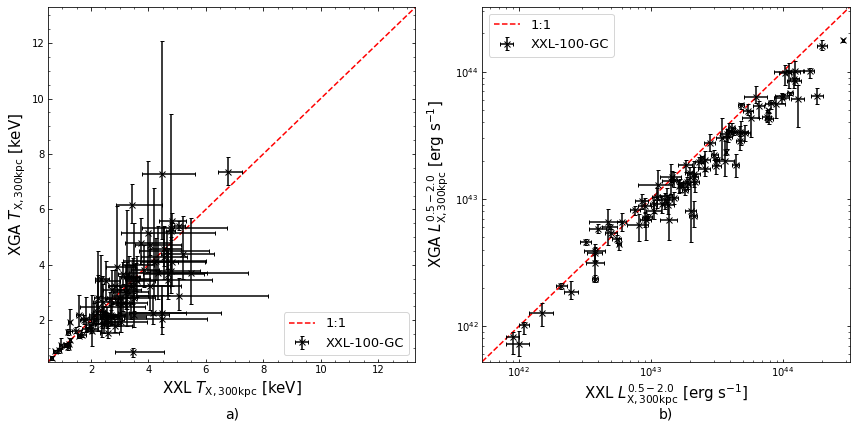

In [28]:
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.15
sublabel_fsize = 14

# Iterating through the array of axes objects, setting up the ticks
for ax_ind, ax in enumerate(ax_arr):
    # Turning on minor ticks and setting it up so they all point inwards - also turn on ticks on the 
    #  top and right axis lines
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')
    # Add the a, b, c, etc labels below the axes
    ax.text(0.5, sublabel_ypos, s='{})'.format(chr(97+ax_ind)), horizontalalignment='center', 
            verticalalignment='center', transform=ax.transAxes, fontsize=sublabel_fsize)

# Setting the leftmost axis to be current
plt.sca(ax_arr[0])
# Using the function we defined earlier to find appropriate axis limits
t_lims = find_lims(xxlgc100_tx, xxl_tx, buffer=0.1).value

# Also using the limits to set up a one to one line
# Then plotting the temperature comparison points
plt.plot(t_lims, t_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(xxlgc100_tx[:, 0].value, xxl_tx[:, 0].value, xerr=xxlgc100_tx[:, 1:].T.value, 
             yerr=xxl_tx[:, 1:].T.value, fmt="kx", capsize=2, label="XXL-100-GC")
# Setting axis limits
plt.xlim(t_lims)
plt.ylim(t_lims)

# Labels and legend
plt.xlabel(r"XXL $T_{\rm{X, 300kpc}}$ [keV]", fontsize=15)
plt.ylabel(r"XGA $T_{\rm{X, 300kpc}}$ [keV]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.sca(ax_arr[1])
l_lims = find_lims(xxlgc100_lx52, xxl_lx, buffer=0.1).value

plt.plot(l_lims, l_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(xxlgc100_lx52[:, 0].value, xxl_lx[:, 0].value, xerr=xxlgc100_lx52[:, 1].value, 
             yerr=xxl_lx[:, 1:].T.value, fmt="kx", capsize=2, label="XXL-100-GC")
plt.xlim(l_lims)
plt.ylim(l_lims)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"XXL $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]", fontsize=15)
plt.ylabel(r"XGA $L^{\rm{0.5-2.0}}_{\rm{X, 300kpc}}$ [erg s$^{-1}$]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.tight_layout()

plt.savefig("non_paper_figures/xxl_Tx_Lx52_comp.pdf")
plt.show()

### LoCuSS

We directly compare temperatures and luminosities measured by LoCuSS - specifically those measured by XMM; LoCuSS used both XMM and Chandra. We have measured more XMM $T_{\rm{X}}$ and $L_{\rm{X}}$ values for the LoCuSS sample than were originally measured, most likely due to the several years of extra data that we have access to.

In [84]:
print('{s} out of {t} XGA Txce measurements were successful'.format(s=np.isfinite(locuss_txce[:, 0]).sum(), 
                                                                  t=len(locuss_txce)))
print('{s} out of {t} XGA Lxbolce measurements were successful'.format(s=np.isfinite(locuss_lxbol[:, 0]).sum(), 
                                                                    t=len(locuss_lxbol)))

46 out of 46 XGA Txce measurements were successful
46 out of 46 XGA Lxbolce measurements were successful


In [86]:
print('There were {n} LoCuSS temperatures originally from Graham'.format(n=np.isfinite(loclit_tx[:, 0]).sum()))

There were 32 LoCuSS temperatures originally from Graham


#### $T_{\rm{X}, 500ce}$ and $L^{\rm{bol}}_{\rm{X}, 500}$

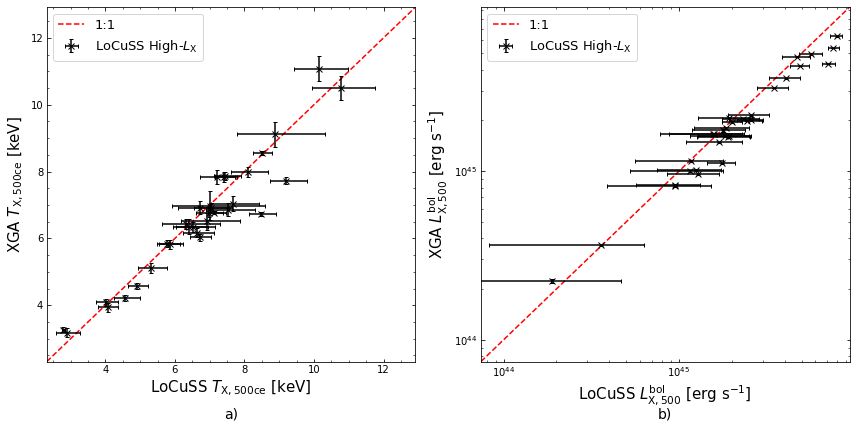

In [29]:
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.15
sublabel_fsize = 14

# Iterating through the array of axes objects, setting up the ticks
for ax_ind, ax in enumerate(ax_arr):
    # Turning on minor ticks and setting it up so they all point inwards - also turn on ticks on the 
    #  top and right axis lines
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')
    # Add the a, b, c, etc labels below the axes
    ax.text(0.5, sublabel_ypos, s='{})'.format(chr(97+ax_ind)), horizontalalignment='center', 
            verticalalignment='center', transform=ax.transAxes, fontsize=sublabel_fsize)
    
# Setting the leftmost axis to be current
plt.sca(ax_arr[0])
# Using the function we defined earlier to find appropriate axis limits
t_lims = find_lims(loclit_tx, locuss_txce, buffer=0.1).value

# Also using the limits to set up a one to one line
# Then plotting the temperature comparison points
plt.plot(t_lims, t_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(loclit_tx[:, 0].value, locuss_txce[:, 0].value, xerr=loclit_tx[:, 1:].T.value, 
             yerr=locuss_txce[:, 1:].T.value, fmt="kx", capsize=2, 
             label=r"LoCuSS High-$L_{\rm{X}}$")
# Setting axis limits
plt.xlim(t_lims)
plt.ylim(t_lims)

# Labels and legend
plt.xlabel(r"LoCuSS $T_{\rm{X, 500ce}}$ [keV]", fontsize=15)
plt.ylabel(r"XGA $T_{\rm{X, 500ce}}$ [keV]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.sca(ax_arr[1])
l_lims = find_lims(loclit_lxbol, locuss_lxbol, buffer=0.1).value
plt.plot(l_lims, l_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(loclit_lxbol[:, 0].value, locuss_lxbol[:, 0].value, xerr=loclit_lxbol[:, 1].value, 
             yerr=locuss_lxbol[:, 1:].T.value, fmt="kx", capsize=2, 
             label=r"LoCuSS High-$L_{\rm{X}}$")
plt.xlim(l_lims)
plt.ylim(l_lims)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"LoCuSS $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.ylabel(r"XGA $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.tight_layout()

plt.savefig("non_paper_figures/locuss_Txce_Lxbol_comp.pdf")
plt.show()

### Lovisari

This compares the temperatures and luminosities (both within $R_{500}$ and core-excluded) measured by Lovisari et al. for their Planck selected cluster sample.

In [90]:
print('{s} out of {t} XGA Tx measurements were successful'.format(s=np.isfinite(lovisari_tx[:, 0]).sum(), 
                                                                  t=len(lovisari_tx)))
print('{s} out of {t} XGA Lx52 measurements were successful'.format(s=np.isfinite(lovisari_lx[:, 0]).sum(), 
                                                                    t=len(lovisari_lx)))
print('{s} out of {t} XGA Lxbol measurements were successful'.format(s=np.isfinite(lovisari_lxbol[:, 0]).sum(), 
                                                                    t=len(lovisari_lxbol)))

115 out of 119 XGA Tx measurements were successful
115 out of 119 XGA Lx52 measurements were successful
115 out of 119 XGA Lxbol measurements were successful


#### $T_{\rm{X}, 500}$, $L^{\rm{0.1-2.4}}_{\rm{X}, 500}$, and $L^{\rm{bol}}_{\rm{X}, 500}$ 

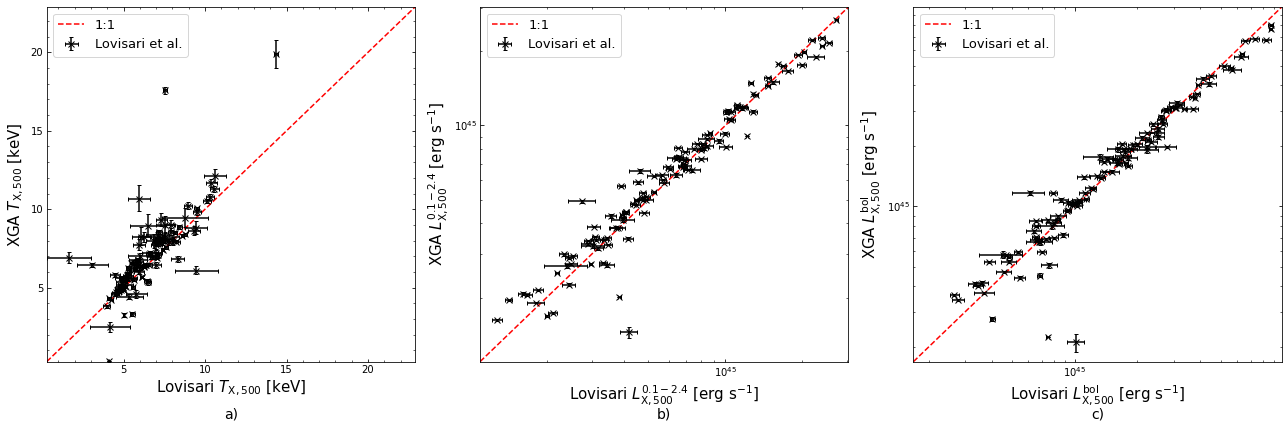

In [31]:
fig, ax_arr = plt.subplots(ncols=3, figsize=(18, 6))

# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.15
sublabel_fsize = 14

# Iterating through the array of axes objects, setting up the ticks
for ax_ind, ax in enumerate(ax_arr):
    # Turning on minor ticks and setting it up so they all point inwards - also turn on ticks on the 
    #  top and right axis lines
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')
    # Add the a, b, c, etc labels below the axes
    ax.text(0.5, sublabel_ypos, s='{})'.format(chr(97+ax_ind)), horizontalalignment='center', 
            verticalalignment='center', transform=ax.transAxes, fontsize=sublabel_fsize)

# Setting the leftmost axis to be current
plt.sca(ax_arr[0])
# Using the function we defined earlier to find appropriate axis limits
t_lims = find_lims(lovlit_tx, lovisari_tx, buffer=0.1).value

# Also using the limits to set up a one to one line
# Then plotting the temperature comparison points
plt.plot(t_lims, t_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(lovlit_tx[:, 0].value, lovisari_tx[:, 0].value, xerr=lovlit_tx[:, 1:].T.value, 
             yerr=lovisari_tx[:, 1:].T.value, fmt="kx", capsize=2, 
             label="Lovisari et al.")
# Setting axis limits
plt.xlim(t_lims)
plt.ylim(t_lims)

# Labels and legend
plt.xlabel(r"Lovisari $T_{\rm{X, 500}}$ [keV]", fontsize=15)
plt.ylabel(r"XGA $T_{\rm{X, 500}}$ [keV]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.sca(ax_arr[1])
l_lims = find_lims(lovlit_lx124, lovisari_lx, buffer=0.1).value

plt.plot(l_lims, l_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(lovlit_lx124[:, 0].value, lovisari_lx[:, 0].value, 
             xerr=lovlit_lx124[:, 1:].T.value, 
             yerr=lovisari_lx[:, 1:].T.value, fmt="kx", capsize=2, 
             label="Lovisari et al.")
plt.xlim(l_lims)
plt.ylim(l_lims)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"Lovisari $L^{\rm{0.1-2.4}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.ylabel(r"XGA $L^{\rm{0.1-2.4}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.sca(ax_arr[2])
l_lims = find_lims(lovlit_lxbol, lovisari_lxbol, buffer=0.1).value

plt.plot(l_lims, l_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(lovlit_lxbol[:, 0].value, lovisari_lxbol[:, 0].value, 
             xerr=lovlit_lxbol[:, 1:].T.value, 
             yerr=lovisari_lxbol[:, 1:].T.value, fmt="kx", capsize=2, 
             label="Lovisari et al.")
plt.xlim(l_lims)
plt.ylim(l_lims)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"Lovisari $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.ylabel(r"XGA $L^{\rm{bol}}_{\rm{X, 500}}$ [erg s$^{-1}$]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.tight_layout()

plt.savefig("non_paper_figures/lovisari_Tx_Lxb_Lx124_comp.pdf")
plt.show()

#### $T_{\rm{X}, 500ce}$, $L^{\rm{0.1-2.4}}_{\rm{X}, 500ce}$, and $L^{\rm{bol}}_{\rm{X}, 500ce}$ 

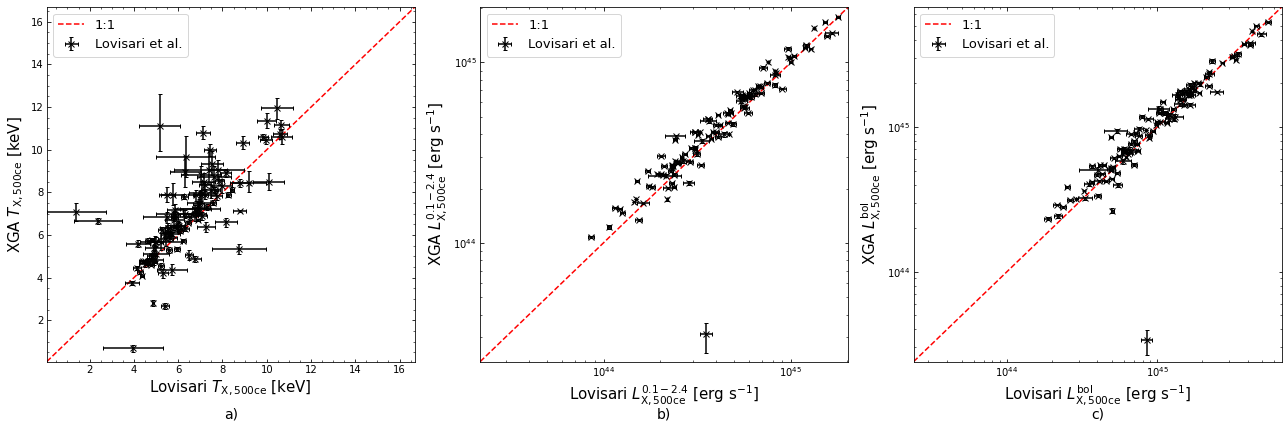

In [32]:
fig, ax_arr = plt.subplots(ncols=3, figsize=(18, 6))

# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.15
sublabel_fsize = 14

# Iterating through the array of axes objects, setting up the ticks
for ax_ind, ax in enumerate(ax_arr):
    # Turning on minor ticks and setting it up so they all point inwards - also turn on ticks on the 
    #  top and right axis lines
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')
    # Add the a, b, c, etc labels below the axes
    ax.text(0.5, sublabel_ypos, s='{})'.format(chr(97+ax_ind)), horizontalalignment='center', 
            verticalalignment='center', transform=ax.transAxes, fontsize=sublabel_fsize)

# Setting the leftmost axis to be current
plt.sca(ax_arr[0])
# Using the function we defined earlier to find appropriate axis limits
t_lims = find_lims(lovlit_txce, lovisari_txce, buffer=0.1).value

# Also using the limits to set up a one to one line
# Then plotting the temperature comparison points
plt.plot(t_lims, t_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(lovlit_txce[:, 0].value, lovisari_txce[:, 0].value, 
             xerr=lovlit_txce[:, 1:].T.value, 
             yerr=lovisari_txce[:, 1:].T.value, fmt="kx", capsize=2, 
             label="Lovisari et al.")
# Setting axis limits
plt.xlim(t_lims)
plt.ylim(t_lims)

# Labels and legend
plt.xlabel(r"Lovisari $T_{\rm{X, 500ce}}$ [keV]", fontsize=15)
plt.ylabel(r"XGA $T_{\rm{X, 500ce}}$ [keV]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.sca(ax_arr[1])
l_lims = find_lims(lovlit_lx124ce, lovisari_lxce, buffer=0.1).value

plt.plot(l_lims, l_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(lovlit_lx124ce[:, 0].value, lovisari_lxce[:, 0].value, 
             xerr=lovlit_lx124ce[:, 1:].T.value, 
             yerr=lovisari_lxce[:, 1:].T.value, fmt="kx", capsize=2, 
             label="Lovisari et al.")
plt.xlim(l_lims)
plt.ylim(l_lims)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"Lovisari $L^{\rm{0.1-2.4}}_{\rm{X, 500ce}}$ [erg s$^{-1}$]", fontsize=15)
plt.ylabel(r"XGA $L^{\rm{0.1-2.4}}_{\rm{X, 500ce}}$ [erg s$^{-1}$]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.sca(ax_arr[2])
l_lims = find_lims(lovlit_lxbolce, lovisari_lxbolce, buffer=0.1).value

plt.plot(l_lims, l_lims, linestyle='dashed', color='red', label="1:1")
plt.errorbar(lovlit_lxbolce[:, 0].value, lovisari_lxbolce[:, 0].value, 
             xerr=lovlit_lxbolce[:, 1:].T.value, 
             yerr=lovisari_lxbolce[:, 1:].T.value, fmt="kx", capsize=2, 
             label="Lovisari et al.")
plt.xlim(l_lims)
plt.ylim(l_lims)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"Lovisari $L^{\rm{bol}}_{\rm{X, 500ce}}$ [erg s$^{-1}$]", fontsize=15)
plt.ylabel(r"XGA $L^{\rm{bol}}_{\rm{X, 500ce}}$ [erg s$^{-1}$]", fontsize=15)
plt.legend(loc='best', fontsize=13)

plt.tight_layout()

plt.savefig("non_paper_figures/lovisari_Tx_Lxb_Lx124_ce_comp.pdf")
plt.show()

### Combined

$\color{red}{\text{I DON'T YET KNOW QUITE HOW TO PRESENT ALL THE COMPARISONS ON ONE PLOT WITHOUT IT BEING A MESS}}$